# Pneumonia Chest X-Ray Classification
Deploying a trained Convolutional Neural Network to classify Pneumonia-infected Chest X-Ray images.

## Code
After training, we can easily deploy our trained model to a web application via [Gradio](https://www.gradio.app/).

In [1]:
import torch
import torchvision
import fastai
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.callback import *
from fastai.metrics import *
import PIL
import gradio as gr
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from timm import create_model

### Loading Trained Model
Before deployment, we have to reload the dataset used as well as the pretrained model. Not all steps here are necessary, but for the sake of completeness and consistency with the training kernel, we added them nonetheless. Most of these should be identical with the tranining notebook, more explanation can be found there.

### Load Data

In [2]:
path = Path("chest_xray/chest_xray")

#### Data Augmentation

In [3]:
batch_tfms = [Normalize.from_stats(*imagenet_stats), *aug_transforms()]

In [4]:
def get_dls(bs: int, size: int):
    '''
    Returns a pair of training and validation dataloaders.

            Parameters:
                    bs (int): Batch size
                    size (int): Size of images after resizing

            Returns:
                    Dataloaders of batch size `bs`
    '''
    dblock = DataBlock(blocks     = (ImageBlock, CategoryBlock),
                       get_items  = get_image_files,
                       get_y      = parent_label,
                       splitter   = GrandparentSplitter(valid_name='val'),
                       item_tfms  = RandomResizedCrop(size, min_scale=0.75),
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(path, bs=bs, num_workers=0).cuda()

In [5]:
dls = get_dls(64, 224)

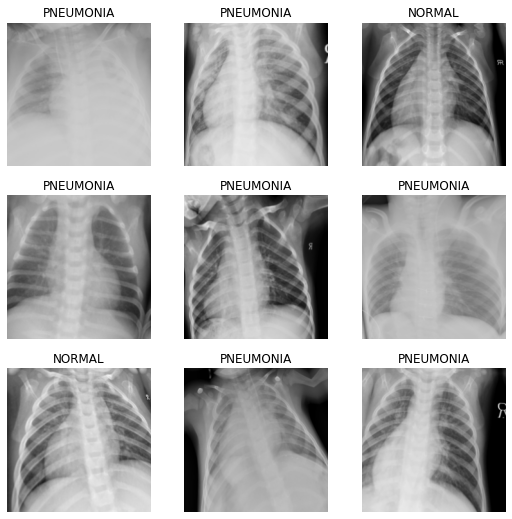

In [6]:
dls.show_batch()

### Model

In [7]:
def create_timm_body(arch: str, pretrained=True, cut=None):
    '''
    Returns the body of a timm model suited to fast.ai.

            Parameters:
                    arch (str): Architecture name
                    pretrained (bool): Load pretrained weights
                    cut: Rule when splitting model

            Returns:
                    A timm model splitted according to given rules and suited for fast.ai `Learner`
    '''
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): 
        return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): 
        return cut(model)
    else: 
        raise NamedError("cut must be either integer or function")

In [8]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [9]:
nf = num_features_model(nn.Sequential(*body.children())) * (2)
head = create_head(nf, dls.c)

In [10]:
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [11]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

### Loading Pretrained Weights

In [15]:
learn = learn.load('efficientnetb3a-1')

### Specify `predict` function
One of Gradio's requirements when creating a web application is to specify a `predict` function which the web app will execute in deployment. Aside from that, we should also specify how to convert the image to a `Tensor` via `PyTorch` and how to normalize the image, which in our case is handled by `torchvision` with Imagenet statistics.

In [23]:
totensor = torchvision.transforms.ToTensor()
normalize_fn = torchvision.transforms.Normalize(*imagenet_stats)

def predict(input: Image):
    '''
    Returns a string of predicted class name and its probability.

            Parameters:
                    input (Image): PIL Image to be predicted

            Returns:
                    res (str): Result after prediction
    '''
    im = TensorImage(normalize_fn(totensor(input)))
    cat, cat_idx, probs = learn.predict(im)
    res = f"Model predicted {cat} with {max(probs):.3f} probability"
    return res

#### Testing `predict` function
Before fully deploying, we can test our function with just one image and see how it fairs.

In [24]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    return img

In [25]:
img = open_image(path/"train/NORMAL/IM-0115-0001.jpeg")

In [26]:
predict(img)

'Model predicted NORMAL with 0.960 probability'

### Deploying via Gradio
After ensuring that everything works, we can finally interface our model with Gradio. We specify our `predict` function, the type of `inputs` (in our case an Image of size 224 by 224), what our `outputs` are (in our case a text, or a string), and the `title` of the web app.

In [27]:
gr_interface = gr.Interface(fn=predict,
                            inputs=gr.inputs.Image(shape=(224, 224)),
                            outputs="text",
                            title='Chest X-Ray Pneumonia Classifier')

gr_interface.launch(inline=False, share=True)

Running locally at: http://127.0.0.1:7860/
This share link will expire in 6 hours. If you need a permanent link, email support@gradio.app
Running on External URL: https://34100.gradio.app


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x15e8619ba60>,
 'http://127.0.0.1:7860/',
 'https://34100.gradio.app')

Gradio will launch the web application and host it locally, which the user can access via the given IP address. The same web application can also be accessed in the given external URL. Note that none of these application are permanent, as they only last for 6 hours.

In application, we can further push this web app to a hosting service like Heroku, for instance.